# 04 - Supervised Learning (LR, DT, RF, SVM)

<Figure size 700x600 with 0 Axes>

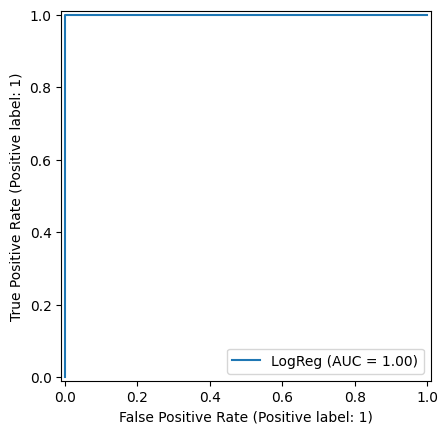

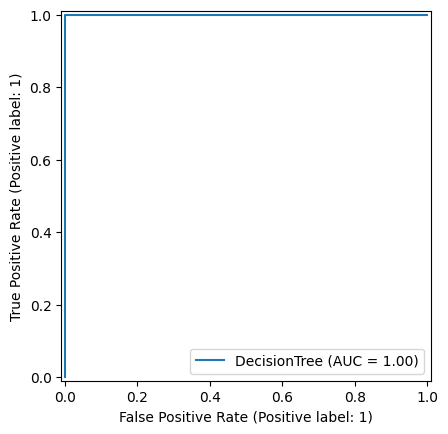

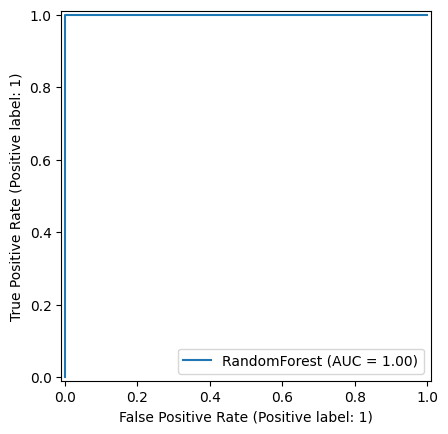

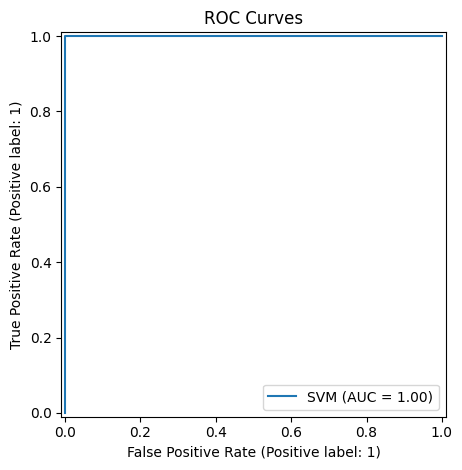

          Model  Accuracy  Precision  Recall        F1  ROC_AUC
0        LogReg  1.000000   1.000000     1.0  1.000000      1.0
1  DecisionTree  1.000000   1.000000     1.0  1.000000      1.0
2  RandomForest  1.000000   1.000000     1.0  1.000000      1.0
3           SVM  0.983607   0.965517     1.0  0.982456      1.0
✅ Saved baseline best model to C:\Users\Moamen\Desktop\Heart_Disease_Project\Heart_Disease_Project\models\best_baseline.pkl


In [1]:
# 04 — Supervised Learning (LR, DT, RF, SVM)

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

# --- Setup robust project paths ---
candidates = [
    Path.cwd().resolve(),
    Path.cwd().resolve().parent,
    Path.cwd().resolve().parent.parent
]

PROJECT_ROOT = None
for cand in candidates:
    if (cand / "data").exists() or (cand / "notebooks").exists():
        PROJECT_ROOT = cand
        break
if PROJECT_ROOT is None:
    PROJECT_ROOT = Path.cwd().resolve()

DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
MODELS_DIR = PROJECT_ROOT / "models"

# Ensure directories exist
DATA_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_PATH = DATA_DIR / "heart_disease_clean.csv"

# --- Load cleaned dataset ---
df = pd.read_csv(CLEAN_PATH)

X = df.drop(columns=['target'])
y = df['target']

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# --- Preprocessing pipeline ---
preprocess = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

# --- Models to evaluate ---
models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

metrics = []
best_auc = -1
best_name = None
best_pipe = None

plt.figure(figsize=(7,6))

# --- Train & evaluate each model ---
for name, clf in models.items():
    pipe = Pipeline(steps=[('prep', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    metrics.append([name, acc, prec, rec, f1, auc])

    RocCurveDisplay.from_predictions(y_test, y_proba, name=name)

    if auc > best_auc:
        best_auc = auc
        best_name = name
        best_pipe = pipe

plt.title('ROC Curves')
plt.tight_layout()
plt.savefig(RESULTS_DIR / "roc_curves.png", dpi=150)
plt.show()

# --- Save metrics ---
metrics_df = pd.DataFrame(metrics, columns=['Model','Accuracy','Precision','Recall','F1','ROC_AUC']).sort_values('ROC_AUC', ascending=False)
print(metrics_df)
metrics_df.to_csv(RESULTS_DIR / "supervised_metrics.csv", index=False)

# --- Save best baseline model ---
best_model_path = MODELS_DIR / "best_baseline.pkl"
joblib.dump(best_pipe, best_model_path)
print("✅ Saved baseline best model to", best_model_path)
